# Implementácia FDTD v 1D 

Obsahom tejto kapitoly je ukážka implementácie Yee algoritmu v jednorozmernom prípade. V takomto prípade budeme predpokladať priestorové usporiadanie zložiek polí E a H podľa nasledujúceho diagramu 

<img src="./img/fdtd_03.png" width=650 alt="Silové pôsobenie dvoch nábojov" scale="1.0">

Simulačné prostredie pre šírenie sa EM vlny v 1D priestore bude o dĺžke 200 uzlov v časovom intervale 300 krokov. $E_z$ a $H_y$ budú uložené v samostatných poliach. Fyzická reprezentácia simulačného prostredia závisí od našej voľby jednotiek, ak pri Courantovom čísle $S_c = 1$ zvolíme priestorový krok  $\Delta x = 1 \, mm$, potom časovému kroku bude zodpovedať doba

\begin{equation*}
\Delta t = S_c \frac{\Delta x}{c} = \frac{1.10^{-3}}{3.10^8} = 3.3.10^{-12} = 3.3 \, ps
\end{equation*}

Elektromagnetickú vlnu vybudíme eletrickou zložkou v tvare exponenciálneho impulzu posunutom v čase voči začiatku simulácia

\begin{equation*}
E_z[0] = \exp \left( -\frac{(t-30)^2}{100} \right) \, [V \, m^{-1}]
\end{equation*}


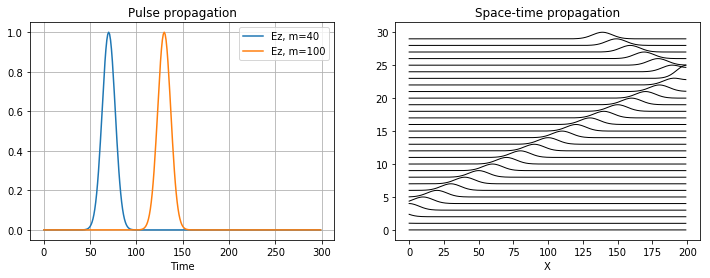

In [43]:
%reset -f 
%matplotlib inline
from scipy import *
import matplotlib.pyplot as plt

nodes = 200
time = 300
ez = zeros(nodes)
hy = zeros(nodes)
z0 = 377.0

r = zeros((time, nodes))                             # pole vysledkov

for t in range(time):
    ez[0] = exp(-(t - 30.)**2 / 100.)                # zdroj E vlny 
    
    for m in range(1,nodes):                         # 1...199
        ez[m] = ez[m] + (hy[m] - hy[m - 1]) * z0     # aktualizacia Ez
    
    for m in range(nodes-1):                         # 0...198
        hy[m] = hy[m] + (ez[m + 1] - ez[m]) / z0     # aktualizacia Hy
        
    r[t,:] += ez

fig = plt.figure(figsize=(12, 4)) 
ax = fig.add_subplot(121) 
ax.plot(r[:,40], label='Ez, m=40')
ax.plot(r[:,100], label='Ez, m=100')
ax.legend()
ax.grid()
plt.xlabel('Time')
plt.title('Pulse propagation')

ax = fig.add_subplot(122)  
for t in range(0, time, 10):
    offset = t*0.1
    ax.plot(range(nodes),r[t]+offset, 'k', lw=1)
plt.xlabel('X')
plt.title('Space-time propagation')
plt.show()


### Okrajové podmienky

V metóde FDTD dôležitú rolu hrajú okrajové podmienky. Z predchádzajúceho príkladu je zrejmé, že na kraji simulačného priestoru dochádza k odrazu vlnenia. Pre analýzu okrajových podmienok predchádzajúci príklad zjednodušíme, veľkosť prostredia obmedzíme na 5 uzlov, ako signál použijeme jednotkový impulz a impedanciu vákua pokladáme za rovnú 1. 


In [45]:
%reset -f 
from scipy import *

def tprint(res_e, res_h, ts, te):
    # formatovana tlac tabulky
    print('        +' +'------+'*5)
    print('        |' +' E  H |'*5)
    print('--------+' +'------+'*5)
    for q in range(ts,te):
        s1 = 'q = {0:2.0f}  '.format(q)
        s2 = ''
        s3 = '        |   '
        for m in range(nodes):
            s2 += '| {0: 1.0f}   '.format(res_e[q,m])
            s3 += '{0: 1.0f} |   '.format(res_h[q,m])
        print(s1 + s2 + '|\n' + s3)
        print('--------+' +'------+'*5)

nodes = 5                                 # pocet uzlov
time = 15                                 # pocet krokov
ez = zeros(nodes)                        
hy = zeros(nodes)

res_e = zeros((time, nodes))
res_h = zeros((time, nodes))

for q in range(time):
    ez[0] = (1 if q==0 else 0)
    
    for m in range(1,nodes):                  
        ez[m] = ez[m] + (hy[m] - hy[m - 1])      # aktualizacia Ez
    
    for m in range(nodes-1): 
        hy[m] = hy[m] + (ez[m + 1] - ez[m])      # aktualizacia Hy
        
    res_h[q,:] += hy  
    res_e[q,:] += ez        

### Generovanie impulzu

Pri generovaní impulzu v prvom kroku nadobudne zdroj EM vlnenia - uzol Ez[0]  hodnotu 1, v ďaľších krokoch bude mať tento uzol nulovú hodnotu bez ohľadu na stav vedľajších uzlov. Simulácia prebieha cyklicky pre celé simulačné prostredie opakovane pre hodnoty m=0...4

                                                               
    Ez[0] = 1                                                 q = 0
    Hy[0] = Hy[0] + (Ez[1] - Ez[0]) = 0 + (0 - 1) = -1        q = 1/2
    ...
                                                              nasledujuci cyklus                                                                                             
    Ez[0] = 0                                                 q = 1
    Hy[0] = 0                                                 q = 1 + 1/2
    Ez[1] = Ez[1] + (Hy[1] - Hy[0]) = 0 + (0 - -1) =  1       q = 1
    Hy[1] = Hy[1] + (Ez[2] - Ez[1]) = 0 + (0 -  1) = -1       q = 1 + 1/2
    ...
    
Z priebehu výpočtu a nasledujúcej tabuľky je zrejmé, ako sa vlna postupne presúva od zdroja k okraju. 

In [46]:
tprint(res_e, res_h, 0, 4)

        +------+------+------+------+------+
        | E  H | E  H | E  H | E  H | E  H |
--------+------+------+------+------+------+
q =  0  |  1   |  0   |  0   |  0   |  0   |
        |   -1 |    0 |    0 |    0 |    0 |   
--------+------+------+------+------+------+
q =  1  |  0   |  1   |  0   |  0   |  0   |
        |    0 |   -1 |    0 |    0 |    0 |   
--------+------+------+------+------+------+
q =  2  |  0   |  0   |  1   |  0   |  0   |
        |    0 |    0 |   -1 |    0 |    0 |   
--------+------+------+------+------+------+
q =  3  |  0   |  0   |  0   |  1   |  0   |
        |    0 |    0 |    0 |   -1 |    0 |   
--------+------+------+------+------+------+


### Odraz na pravej strane prostredia

Cyklickým prepočítavaním postupne prejdeme k vyhodnoteniu stavu na pravom okraji. Pretože cyklus pre Hy končí pri hodnote m-1, bude hodnota Hy[m] rovná vždy 0.
                                                             
    Ez[3] = Ez[3] + (Hy[3] - Hy[2]) = 0 + (0 - -1) =  1       q = 3
    Hy[3] = Hy[3] + (Ez[4] - Ez[3]) = 0 + (0 -  1) = -1       q = 3 + 1/2
    Ez[4] = 0                                                 q = 3
    Hy[4] = 0                                                 q = 3 + 1/2
    ...
    Ez[3] = 0                                                 q = 4
    Hy[3] = 0                                                 q = 4 + 1/2
    Ez[4] = Ez[4] + (Hy[4] - Hy[3]) = 0 + (0 - -1) =  1       q = 4
    Hy[4] = 0                                                 q = 4 + 1/2
    
Pri nasledujúcom cykle preto nedôjde k zmene hodnoty Ez, pretože hodnota Hy v poslednom uzle je rovná 0. 

    Ez[3] = Ez[3] + (Hy[3] - Hy[2]) = 0 + (0 -  0) =  0       q = 5
    Hy[3] = Hy[3] + (Ez[4] - Ez[3]) = 0 + (1 -  0) =  1       q = 5 + 1/2
    Ez[4] = Hy[3] + (Ez[4] - Ez[3]) = 0 + (1 -  0) =  1       q = 5
    Hy[4] = 0                                                 q = 5 + 1/2
    ...
    Ez[3] = Ez[3] + (Hy[3] - Hy[2]) = 0 + (1 -  0) =  1       q = 6
    Hy[3] = Hy[3] + (Ez[4] - Ez[3]) = 0 + (1 -  1) =  0       q = 6 + 1/2
    Ez[4] = Ez[4] + (Hy[4] - Hy[3]) = 1 + (0 -  1) =  0       q = 6
    Hy[4] = 0                                                 q = 6 + 1/2
    
Pri odraze sa elektrická zložka zachovala, magnetická otočila, z technického hľadiska takýto stav zodpovedá odrazu vlnenia na voľnom konci vedenia. V terminológii FDTD sa takyto uzol označuje ako PMC (Perfect Magnetic Conductor).

In [49]:
tprint(res_e, res_h, 3, 7)

        +------+------+------+------+------+
        | E  H | E  H | E  H | E  H | E  H |
--------+------+------+------+------+------+
q =  3  |  0   |  0   |  0   |  1   |  0   |
        |    0 |    0 |    0 |   -1 |    0 |   
--------+------+------+------+------+------+
q =  4  |  0   |  0   |  0   |  0   |  1   |
        |    0 |    0 |    0 |    0 |    0 |   
--------+------+------+------+------+------+
q =  5  |  0   |  0   |  0   |  0   |  1   |
        |    0 |    0 |    0 |    1 |    0 |   
--------+------+------+------+------+------+
q =  6  |  0   |  0   |  0   |  1   |  0   |
        |    0 |    0 |    1 |    0 |    0 |   
--------+------+------+------+------+------+


### Odraz na ľavej strane vedenia

Po vygenerovaní impulzu má elektrická zložka v uzle [0] nulovú hodnotu, čo zodpovedá pripojenému zdroju napätia s nulovým odporom, z vlnového hladiska je to ekvivalent skratovaného vedenia. Podobným rozborom ako bolo uvedené vyššie sa zistíme, že elektická zložka sa otočila, magnetická zostala zachovaná, toto zodpovedá odrazu vlnenia na pevnom resp. skratovanom konci. V terminológii FDTD sa takyto uzol označuje ako PEC (Perfect Electric Conductor).

In [50]:
tprint(res_e, res_h, 7, 11)

        +------+------+------+------+------+
        | E  H | E  H | E  H | E  H | E  H |
--------+------+------+------+------+------+
q =  7  |  0   |  0   |  1   |  0   |  0   |
        |    0 |    1 |    0 |    0 |    0 |   
--------+------+------+------+------+------+
q =  8  |  0   |  1   |  0   |  0   |  0   |
        |    1 |    0 |    0 |    0 |    0 |   
--------+------+------+------+------+------+
q =  9  |  0   |  0   |  0   |  0   |  0   |
        |    1 |    0 |    0 |    0 |    0 |   
--------+------+------+------+------+------+
q = 10  |  0   | -1   |  0   |  0   |  0   |
        |    0 |    1 |    0 |    0 |    0 |   
--------+------+------+------+------+------+


Pre simuláciu EM vlnenia vo voľnom priestore je potrebné definovať okrajové podmienky prostredia tak, aby nedochádzalo k odrazom a následným interferenciám. Vytvorenie bezodrazových alebo impedančne prispôsobených okrajových podmienok bude diskutované v nasledujúcich kapitolách.